In [7]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from IPython.display import display
import numpy as np
import os
import torch
from PIL import Image, ImageDraw

# SOMMAIRE

##### [Introduction](#dim)

##### I -  [Experiments setup](#Experiments)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A - [Methods](#Methodes)    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;B - [Time to proceed experiment on 1 image](#Timeexp1im)  
##### II -  [Precision Analysis ](#precision)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - [Methods comparaison](#Methodes)   
##### III -  [Time](#Time)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - [Methods comparaison](#Methodes)   
##### III -  [Complexity](#Complexity)

# <a id="Complexity"></a> Complexity

detailed line by line breakdown of execution time - optimizing code

In [37]:
from line_profiler import LineProfiler

## Many perturbations results

In [172]:
folder_path = "/Users/ncohmpli/Documents/Professionnel/Technical/Verification/Lirpa for IoU/manip/pipeline/lirpa_iou_pipeline/results/many_exp_true/"

In [173]:
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

In [174]:
dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, converters={ 'IoU_vanilla':pd.eval,'IoU_extension':pd.eval,'IoU_extension_greedy':pd.eval})
    dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)

In [175]:
combined_df = combined_df.sort_values(by="image_id")

In [176]:
combined_df["IoU_vanilla_delta"] = combined_df.IoU_vanilla.apply(lambda x: x[1]-x[0])
combined_df["IoU_extension_delta"] = combined_df.IoU_extension.apply(lambda x: x[1]-x[0])

combined_df["Vanilla_upper"] = combined_df.IoU_vanilla.apply(lambda x: x[1])
combined_df["Vanilla_lower"] = combined_df.IoU_vanilla.apply(lambda x: x[0])
combined_df["Extension_upper"] = combined_df.IoU_extension.apply(lambda x: x[1])
combined_df["Extension_lower"] = combined_df.IoU_extension.apply(lambda x: x[0])

In [180]:
eps0 = combined_df[combined_df["eps"]==0]
bad_images_extension = np.unique(eps0[eps0["IoU_extension_delta"]>0.0001]["image_id"])
bad_images_vanilla = np.unique(eps0[eps0["IoU_vanilla_delta"]>0.0001]["image_id"])
def bad_images(im):
    if (im in bad_images_extension) or (im in bad_images_vanilla):
        return(True)
    return(False)
combined_df["bad_images"] = combined_df["image_id"].apply(lambda x: bad_images(x))
combined_df = combined_df[combined_df["bad_images"] == False]

In [181]:
combined_df = combined_df[combined_df["eps"] <= 0.0009]

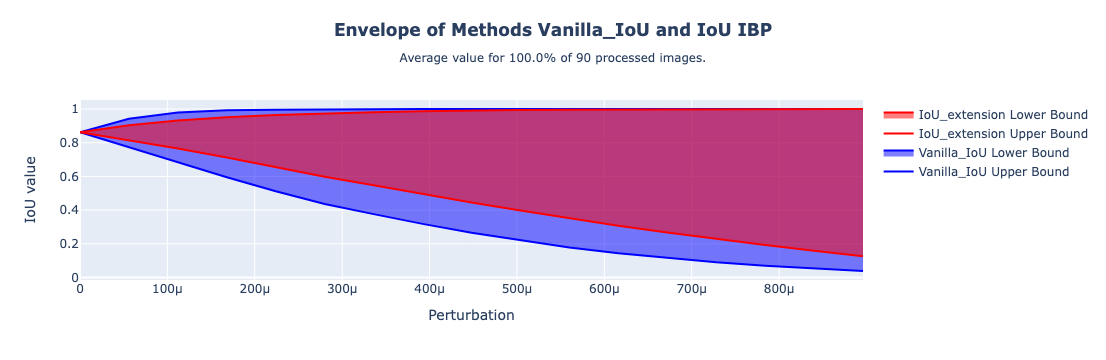

In [182]:
def envelop_graph(df_grouped, title='Envelope of Methods Vanilla_IoU and IoU IBP', subtitle=None, subsubtitle=""):
    """df should have the columns
    "Eps" "Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"
    """

    trace_A = go.Scatter(
        x=df_grouped["eps"],
        y=df_grouped["Vanilla_upper"],
        fill=None,
        mode='lines',
        line=dict(color='blue'),
        name='Vanilla_IoU Upper Bound'
    )
    trace_A_lower = go.Scatter(
        x=df_grouped["eps"],
        y=df_grouped["Vanilla_lower"],
        fill='tonexty',  # Espace remplissage ! 
        mode='lines',
        line=dict(color='blue'),
        name='Vanilla_IoU Lower Bound'
    )
    trace_B = go.Scatter(
        x=df_grouped["eps"],
        y=df_grouped["Extension_upper"],
        fill=None,
        mode='lines',
        line=dict(color='red'),
        name='IoU_extension Upper Bound'
    )
    trace_B_lower = go.Scatter(
        x=df_grouped["eps"],
        y=df_grouped["Extension_lower"],
        fill='tonexty',  # Espace remplissage ! 
        mode='lines',
        line=dict(color='red'),
        name='IoU_extension Lower Bound'
    )
    
    layout = go.Layout(
        title=title,
        xaxis=dict(title='Perturbation'),
        yaxis=dict(title='IoU value')
    )
    
    fig = go.Figure(layout=layout)
    fig.add_trace(trace_A)
    fig.add_trace(trace_A_lower)
    fig.add_trace(trace_B)
    fig.add_trace(trace_B_lower)

    if subtitle != None:
        fig.update_layout(
            title={'text': f'<b>{title}</b><br><sub>{subtitle}</sub><br><sub><i>{subsubtitle}</i></sub>',
           'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'}
            )


    return(fig)

df_grouped = combined_df.groupby("eps")[["Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"]].agg("mean")
df_grouped = df_grouped.reset_index()

def percentage_value(df_plotted, df=df):
    """Percentage images processed on this plot
    """
    plotted = len(np.unique(list(df_plotted["image_id"])))
    globaldf = len(np.unique(list(df["image_id"])))
    return((plotted/globaldf)*100)
nb_im_proc = combined_df.groupby("image_id")[["eps"]].agg("count").shape[0]
envelop_graph(df_grouped, title=f'Envelope of Methods Vanilla_IoU and IoU IBP', subtitle=f"Average value for {percentage_value(df)}% of {nb_im_proc} processed images.")

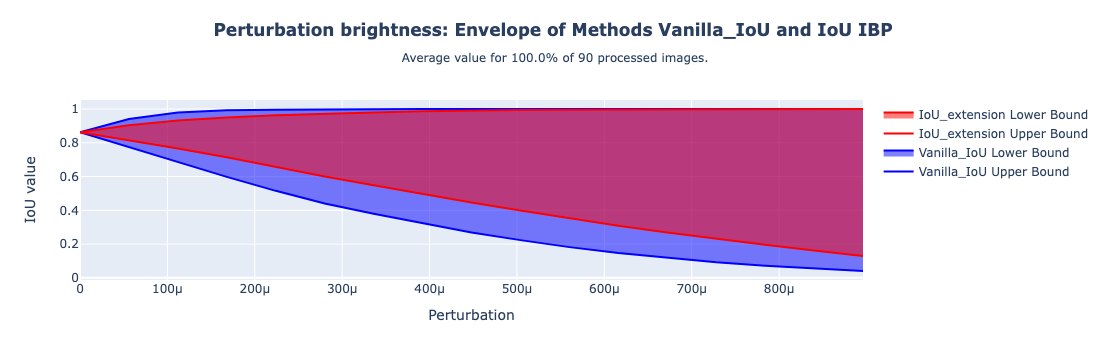

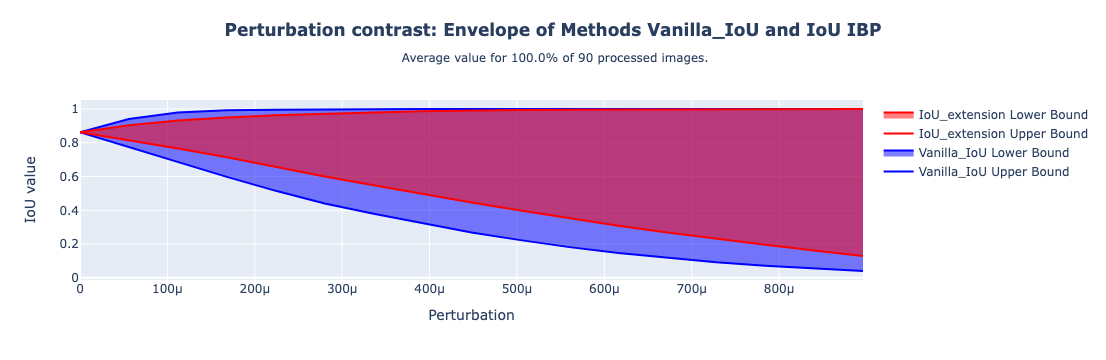

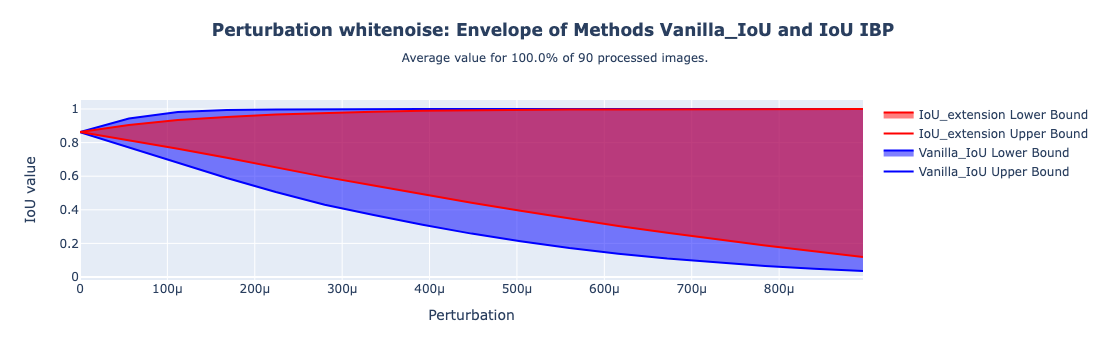

In [204]:
for perturbation_i in np.unique(combined_df["perturbation"]):
    df_grouped = combined_df[combined_df["perturbation"] == perturbation_i].groupby("eps")[["Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"]].agg("mean")
    df_grouped = df_grouped.reset_index()
    envelop_graph(df_grouped, title=f'Perturbation {perturbation_i}: Envelope of Methods Vanilla_IoU and IoU IBP', subtitle=f" Average value for {percentage_value(df)}% of {nb_im_proc} processed images.").show()

In [205]:
def display_im(idx):
    im4 = torch.tensor([images.iloc[idx][1:]])
    im4 = im4.view((-1, 1, 90, 90))
    im4 = im4.squeeze()
    im4 = im4.mul(255).byte()
    pil_image = Image.fromarray(im4.cpu().numpy(), mode="L")
    draw = ImageDraw.Draw(pil_image)
    pil_image.show()

# <a id="Time"></a> Time analysis

In [195]:
'elapsed_time_eps_computed_ious'
describe_tmps


,tmps_vanilla,tmps_extension
count,1530.000000,1530.000000
mean,0.000059,0.007322
std,0.000006,0.000337
min,0.000046,0.006046
25%,0.000055,0.007115
50%,0.000057,0.007284
75%,0.000064,0.007460
max,0.000101,0.012397


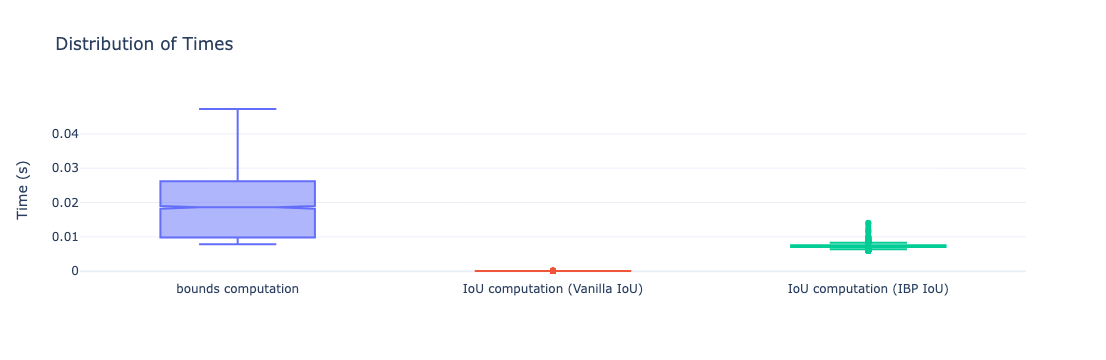

In [203]:
def create_box_plot(df, columns):
    df_long = df.melt(value_vars=columns, var_name='Time', value_name='Value')
    fig = px.box(df_long, x='Time', y='Value', color='Time', 
                 notched=True,  
                 title='Distribution of Times')

    fig.update_layout(
        yaxis_title='Time (s)',  
        xaxis_title='',
        template='plotly_white',  
        showlegend=False  
    )
    
    fig.show()


create_box_plot(combined_df.rename(columns={
    'elapsed_time_eps_computed_ious':'bounds computation',
    "tmps_vanilla":'IoU computation (Vanilla IoU)',
    "tmps_extension":'IoU computation (IBP IoU)'}), ['bounds computation', 'IoU computation (Vanilla IoU)',	'IoU computation (IBP IoU)'])

In [199]:
combined_df.columns

Index(['Unnamed: 0', 'image_id', 'gt_logit', 'eps', 'fake_iou', 'perturbation',
       'bounds_clip', 'elapsed_time_perturbation',
       'elapsed_time_eps_computed_ious', 'IoU_vanilla', 'tmps_vanilla',
       'IoU_extension', 'tmps_extension', 'IoU_vanilla_delta',
       'IoU_extension_delta', 'Vanilla_upper', 'Vanilla_lower',
       'Extension_upper', 'Extension_lower', 'bad_images'],
      dtype='object')

# Best or worst images 

In [206]:
df_groupybimage = combined_df.groupby("image_id")[["IoU_vanilla_delta",	"IoU_extension_delta"]].agg("mean")
df_groupybimage["enveloppe_diff"] = df_groupybimage["IoU_vanilla_delta"]-df_groupybimage["IoU_extension_delta"]

In [207]:
df_groupybimage

,IoU_vanilla_delta,IoU_extension_delta,enveloppe_diff
image_id,,,
0,0.621432,0.484467,0.136964
1,0.636969,0.510091,0.126879
2,0.604292,0.427815,0.176478
3,0.698698,0.522650,0.176048
5,0.597241,0.405055,0.192187
...,...,...,...
94,0.694717,0.534120,0.160597
95,0.666378,0.476646,0.189732
97,0.671837,0.494304,0.177534
